# Anniversary Analysis

## TOC:
* [Description](#description)
* [Parsing the info](#parsing_info)
    * [Facebook](#facebook)
    * [WhatsApp](#whatsapp)
* [Data Preparation](#preparation)
* [Data Exploration](#exploration)
    * [How many messages?](#how_many)
    * [Message exchange per day](#messages_day)
    * [Message exchange per week](#messages_week)
        * [Why FB gap in April?](#gap_april)
        * [Some FB landmarks](#fb_landmarks)
    * [Who said it first](#first)
    * [Who said it more?](#more)
    * [LOVE distribution per weeks](#love_weeks)
    * [Any preferred days to communicate?](#preferred_days)
    * [What about the hours?](#preferred_hours)
* [Further exploration: playing with words (NLP)](#nlp)
    * [Word Frequency](#frequency)
        * [Bigrams](#bigrams)
        * [Trigrams](#trigrams)
    * [Topic detection](#topic)
    * [Sentiment analysis](#sentiment)
* [Annex](#annex)

## Description <a class="anchor" id="description"></a>

My partner and I met under very random circumstances. Some call it fate! ❤️

Anyway, after spending __only two__ days together we decided that our story couldn't end there. So, despite the fact that she went back to California, we tried to shorten the ~__6,000 mi__ (~9,500 km) that separeted us through online conversations.

We started using [Facebook Messenger](https://www.messenger.com/) for most of our communications. Then, we also started using [WhatsApp](https://www.whatsapp.com/), so there is a lot of data stored about us! 

As our first year anniversary is approaching, and because I'm a super data nerd, I decided to explore a little bit our conversations. 

This is not intended to be a sickeningly sweet Notebook. It's mostly a way to share how quickly one can obtain insights on data, but due to its nature you might find yourself involved into some rainbow stuff 🌈 🦄. 

General imports:

In [1]:
from bs4 import BeautifulSoup
import csv
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Parsing the info <a class="anchor" id="parsing_info"></a>

### Facebook <a class="anchor" id="facebook"></a>

Facebook includes an option that allows you to download __ALL__ the information you have ever shared in their platform.

In a folder called `messages` it stores all your Messenger conversations and files shared. The download consists of a set of `.html` files for every conversation you have ever had. 

The initial idea is to parse the `.html` files and store them into a `.csv` file to get rid of all unnecessary tags.

In [2]:
content_path = './messages/487.html'
f = open(content_path, 'r')
raw_content = f.read()
f.close()

In [3]:
soup = BeautifulSoup(raw_content, 'html.parser')

In [4]:
pretty_lines = soup.prettify().splitlines()

Exploring a little bit the document structure we realize that there is a lot of `css` content at the beginning.

In [5]:
pretty_lines[:5]

[u'<html>',
 u' <head>',
 u'  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>',
 u'  <base href="../"/>',
 u'  <style type="text/css">']

Spotting a message example we detect the flags `message`, `message_header` (containing the `user`), `meta` (the date) and the content of the message in a `p`element.

In [6]:
pretty_lines[149:164]

[u'   <div class="message">',
 u'    <div class="message_header">',
 u'     <span class="user">',
 u'      Guiem Bosch',
 u'     </span>',
 u'     <span class="meta">',
 u'      Saturday, January 6, 2018 at 9:35am UTC',
 u'     </span>',
 u'    </div>',
 u'   </div>',
 u'   <p>',
 u'    <p>',
 u'     <img src="messages/gifs/10155311765535197.gif"/>',
 u'    </p>',
 u'   </p>']

Finding all messages!

In [7]:
messages = soup.find_all("div", class_="message")

In [8]:
len(messages)

32767

In [9]:
for idx,m in enumerate(messages):
    print m
    if idx == 4: # only printing the first 5 messages to see their content
        break    

<div class="message"><div class="message_header"><span class="user">Jisu Zephyr Youn</span><span class="meta">Saturday, January 6, 2018 at 9:36am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Guiem Bosch</span><span class="meta">Saturday, January 6, 2018 at 9:35am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Jisu Zephyr Youn</span><span class="meta">Saturday, January 6, 2018 at 9:35am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Jisu Zephyr Youn</span><span class="meta">Saturday, January 6, 2018 at 9:35am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Jisu Zephyr Youn</span><span class="meta">Saturday, January 6, 2018 at 9:35am UTC</span></div></div>


__Ooops!__ Because the content of the message is not stored into the `div` element we cannot retrieve it. It looks like we are going to navigate down to the first `message` element and keep with the iteration.

In [10]:
thread = soup.find("div",class_="thread")

Dumping the cleaned data into a `.csv` file

In [38]:
outputcsv_path = './messages/messages.csv'
with open(outputcsv_path, 'w') as csvfile:
    fieldnames = ['user', 'date', 'text', 'source']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for idx, child in enumerate(thread.children):
        if child.name == 'div':
            message_header = child.find("div", class_='message_header')
            user = message_header.find("span", class_="user").get_text()
            date = message_header.find("span", class_="meta").get_text()
        elif child.name == 'p':
            li = child.find("li") # <li> element contains a Like to a specific message, we can discard it
            if li:
                li.extract()
            text = child.get_text()
            writer.writerow({'user': user.encode('utf-8'), 'date': date.encode('utf-8'), 'text': text.encode('utf-8'),
                            'source':'facebook'})

### WhatsApp <a class="anchor" id="whatsapp"></a>

WhatsApp allows you to send a specific chat conversation to an e-mail address. The result is a `.txt` file (note: one can choose to include the media files but it has been considered irrelevant in this case).

In [39]:
outputcsv_path = './messages/messages.csv'
file_paths = ['./messages/whatsapp1.txt','./messages/whatsapp2.txt']
with open(outputcsv_path, 'a') as csvfile:
    fieldnames = ['user', 'date', 'text', 'source']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    for f_path in file_paths:
        with open(f_path,'r') as f:
            for l in f.readlines():
                if len(l) > 0 and l[0].isdigit():
                    l = l.replace("+1 (626) 437-","J.") # one file contains her old number
                    if '-' in l:
                        date = l.split('-')[0].replace(',','').rstrip()
                        user_text = l.split('-')[1].split(':')
                        user = user_text[0].lstrip()
                        text = user_text[1].rstrip()
                        writer.writerow({'user': user, 'date': date,'text': text,'source':'whatsapp'})

## Data Preparation <a class="anchor" id="preparation"></a>

In [48]:
csv_data_path = './messages/messages.csv'
df = pd.read_csv(csv_data_path)

In [49]:
df['date'].dtype

dtype('O')

Dates are regular objects. We'll probably want to compare events in time. Let's convert them to `datetime` objects!

In [50]:
df['datetime'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['datetime'].dtype

dtype('<M8[ns]')

Also, to avoid unnecessary exposure, let's just obfuscate her name 😉

In [52]:
df.loc[df['user'].str.contains('J'),'user'] = 'J.'

In [53]:
df.user.unique()

array(['J.', 'Guiem Bosch'], dtype=object)

WhatsApp replaces media content by `<Media omitted>` if one has chosen to avoid media. We should clean this too.

In [61]:
df.loc[df['text'].str.contains('<Media omitted>',na=False),'text'] = np.nan

Finally we save the dataframe as it is so we can load it anytime

In [63]:
csv_data_clean_path = './messages/messages_clean.csv'
df.to_csv(csv_data_clean_path,index=False)

Loading "prepared" data

In [7]:
csv_data_clean_path = './messages/messages_clean.csv'
parse_dates = ['datetime']
df = pd.read_csv(csv_data_clean_path, parse_dates = parse_dates)

## Data Exploration <a class="anchor" id="exploration"></a>

### How many messages? <a class="anchor" id="how_many"></a>

In [63]:
df.text.count()

75332

__<font color=gray>OMG!</font> <font color=pink>75,332</font>  <font color=gray>messages!</font>__

Back in the day, when my grandparents were taken apart due to war issues 😤  they would send a letter to each other every 6 months. 

Whereas us, in almost one year, exchanged ~75K text messages! Isn't that crazy? The postmodernism's culture of immediacy, I guess...  

### Message exchange per day <a class="anchor" id="messages_day"></a>

In [71]:
messages_day_f = df[df.source=='facebook'].groupby(pd.Grouper(key="datetime", freq='D')).count()

In [4]:
messages_day_w = df[df.source=='whatsapp'].groupby(pd.Grouper(key="datetime", freq='D')).count()

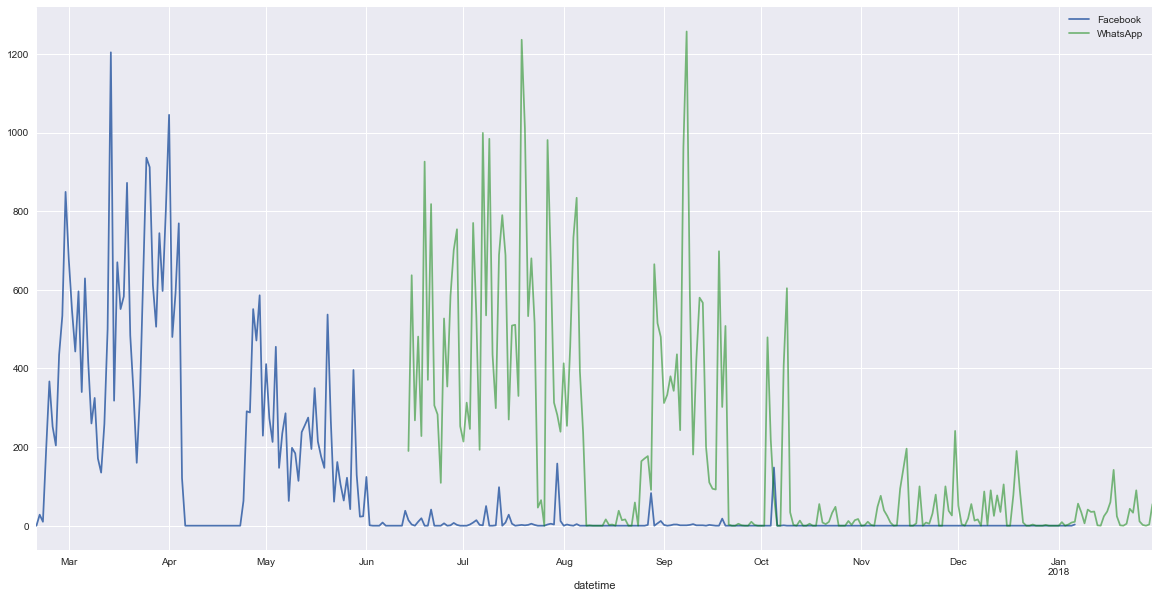

In [24]:
messages_day_f.text.plot(figsize=(20,10),label='Facebook')
messages_day_w.text.plot(figsize=(20,10),style='g',alpha=0.5,label='WhatsApp')
plt.legend(loc='best')

We can clearly observe a transition from Facebook Messenger to WhatsApp by mid June. We met by the start of June and I think she just saw I was using mostly WhatsApp to communicate with my friends...

### Message exchange per week <a class="anchor" id="messages_week"></a>

Day by day number of messages exchanged look a bit messy, what about gathering the info by weeks?

In [68]:
messages_week_f = df[df.source=='facebook'].groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

In [65]:
messages_week_w = df[df.source=='whatsapp'].groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

Text(50,50,u'Trip Italy')

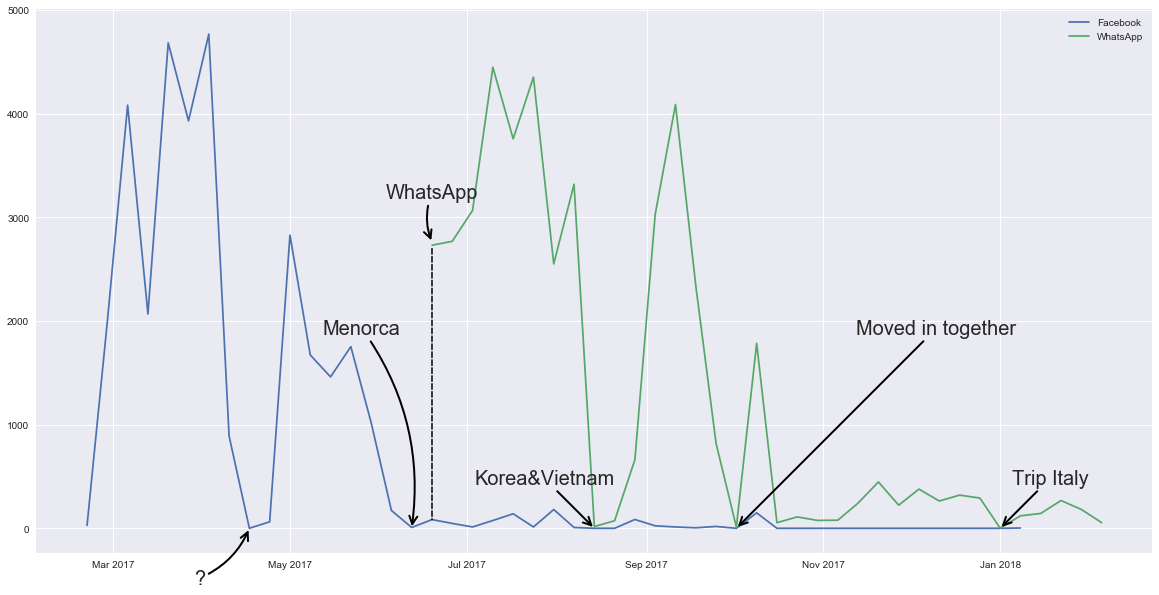

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
plt.plot(messages_week_f.text,label='Facebook')
plt.plot(messages_week_w.text,label='WhatsApp')
plt.legend(loc='best')
plt.annotate('?', (mdates.date2num(dt.datetime(2017,4,17)),0), xytext=(-50, -50),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.2",lw=2),
           )
plt.annotate('Menorca', (mdates.date2num(dt.datetime(2017,6,12)),0), xytext=(-50, 200),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=-0.2",lw=2),
           )
plt.annotate('WhatsApp', (mdates.date2num(dt.datetime(2017,6,19)),2759), xytext=(0, 50),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2",
                            lw=2),
           )
plt.annotate('', (mdates.date2num(dt.datetime(2017,6,19)),65), xytext=(0, 275),
            textcoords='offset points', size=20, va="center",
            arrowprops=dict(arrowstyle="-",ls='dashed',lw=1.5),
           )
plt.annotate('Korea&Vietnam', (mdates.date2num(dt.datetime(2017,8,14)),0), xytext=(-50, 50),
            textcoords='offset points', size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",lw=2),
           )
plt.annotate('Moved in together', (mdates.date2num(dt.datetime(2017,10,2)),0), xytext=(200, 200),
            textcoords='offset points', size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",lw=2),
           )
plt.annotate('Trip Italy', (mdates.date2num(dt.datetime(2018,1,1)),0), xytext=(50, 50),
            textcoords='offset points', size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",lw=2),
           )

We observe that valleys in the communication graph depict "togetherness". Pretty obvious, right?! But what about the first gap...?

#### Why that FB gap in April? <a class="anchor" id="gap_april"></a>

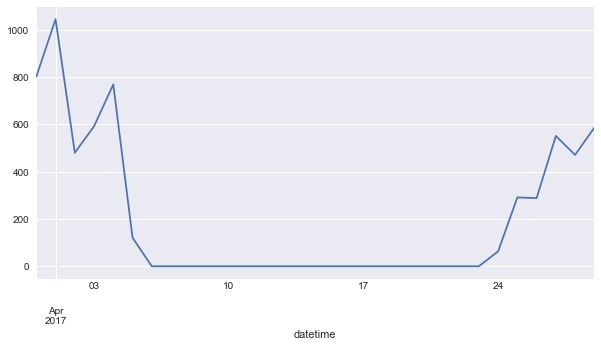

In [73]:
messages_day_f[40:70].text.plot(figsize=(10,5))

In [75]:
messages_day_f[40:70].text

datetime
2017-03-31     802
2017-04-01    1045
2017-04-02     480
2017-04-03     592
2017-04-04     769
2017-04-05     121
2017-04-06       0
2017-04-07       0
2017-04-08       0
2017-04-09       0
2017-04-10       0
2017-04-11       0
2017-04-12       0
2017-04-13       0
2017-04-14       0
2017-04-15       0
2017-04-16       0
2017-04-17       0
2017-04-18       0
2017-04-19       0
2017-04-20       0
2017-04-21       0
2017-04-22       0
2017-04-23       0
2017-04-24      63
2017-04-25     291
2017-04-26     288
2017-04-27     551
2017-04-28     471
2017-04-29     586
Freq: D, Name: text, dtype: int64

After verifying that some days definetly had null values for communication I went to investigate the raw data. I found that messages were missing for those days in the downloaded file but present when queried through the app. After downlading the data again and seeing no changesI notified this to Facebook. A bug maybe? 🤔

#### Some FB landmarks <a class="anchor" id="fb_landmarks"></a>

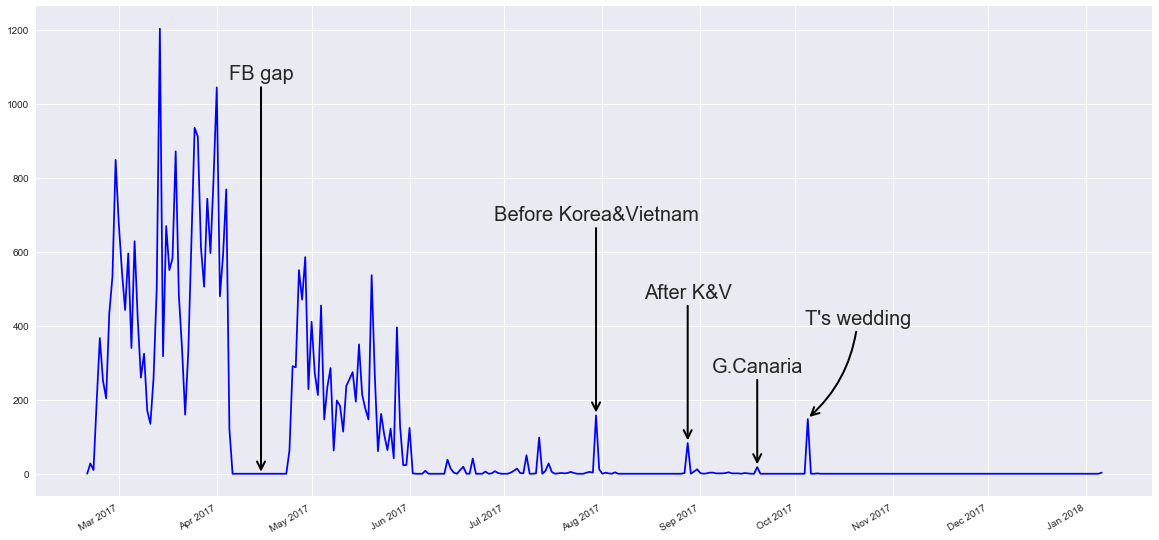

In [81]:
fig, ax = plt.subplots()
plt.plot(messages_day_f.text,'b')
fig.set_size_inches(20,10)
ax.annotate('FB gap', (mdates.date2num(dt.datetime(2017,4,15)),0), xytext=(0, 400),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate('Before Korea&Vietnam', (mdates.date2num(dt.datetime(2017,7,30)),160), xytext=(0, 200),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate('After K&V', (mdates.date2num(dt.datetime(2017,8,28)),85), xytext=(0, 150),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate('G.Canaria', (mdates.date2num(dt.datetime(2017,9,19)),20), xytext=(0, 100),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate("T's wedding", (mdates.date2num(dt.datetime(2017,10,5)),150), xytext=(50, 100),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
fig.autofmt_xdate()

Peaks in communication usually anticipate moments when we were about to see each other 👀

### Who said it first? <a class="anchor" id="first"></a>

We know everything happened really fast, but who said "__I love you__" first? 

In [76]:
df[df['text'].str.contains("i love you", case=False) == True].sort_values(by='datetime').head(10)

,user,date,text,source,datetime
31867,Guiem Bosch,"Saturday, February 25, 2017 at 1:11pm UTC","""Hi, Jisu!\nI have to admit I've been contempl...",facebook,2017-02-25 13:11:00
31855,J.,"Saturday, February 25, 2017 at 1:32pm UTC","I hope you will, and maybe I'll come find you,...",facebook,2017-02-25 13:32:00
31837,J.,"Saturday, February 25, 2017 at 3:38pm UTC",I love your soul,facebook,2017-02-25 15:38:00
31627,J.,"Sunday, February 26, 2017 at 12:22am UTC","I love you, not in the traditional possessive ...",facebook,2017-02-26 00:22:00
31626,Guiem Bosch,"Sunday, February 26, 2017 at 12:23am UTC",I love you,facebook,2017-02-26 00:23:00
31624,Guiem Bosch,"Sunday, February 26, 2017 at 12:24am UTC",I love you because there is no alternative,facebook,2017-02-26 00:24:00
31559,Guiem Bosch,"Sunday, February 26, 2017 at 4:02am UTC",I love you!!!,facebook,2017-02-26 04:02:00
31422,J.,"Sunday, February 26, 2017 at 9:40pm UTC",I love you,facebook,2017-02-26 21:40:00
31318,Guiem Bosch,"Sunday, February 26, 2017 at 10:06pm UTC","I love you, Jisu",facebook,2017-02-26 22:06:00
31313,J.,"Sunday, February 26, 2017 at 10:07pm UTC","I love you, too, guiem!",facebook,2017-02-26 22:07:00


An alternative query to match with the exact words, to avoid cases like "__I love you__r soul"

In [77]:
love_tests = pd.Series(["I love you","i looooove you so much", "i love you!!!!", "i love youtube", "i love your soul"]) 

In [78]:
love_tests.str.contains(r"i lo+ve+ yo+u+\b.*", case=False)

0     True
1     True
2     True
3    False
4    False
dtype: bool

In [79]:
df[df['text'].str.contains(r"i lo+ve+ yo+u+\b.*", case=False) == True].sort_values(by='datetime').head(10)

,user,date,text,source,datetime
31867,Guiem Bosch,"Saturday, February 25, 2017 at 1:11pm UTC","""Hi, Jisu!\nI have to admit I've been contempl...",facebook,2017-02-25 13:11:00
31855,J.,"Saturday, February 25, 2017 at 1:32pm UTC","I hope you will, and maybe I'll come find you,...",facebook,2017-02-25 13:32:00
31627,J.,"Sunday, February 26, 2017 at 12:22am UTC","I love you, not in the traditional possessive ...",facebook,2017-02-26 00:22:00
31626,Guiem Bosch,"Sunday, February 26, 2017 at 12:23am UTC",I love you,facebook,2017-02-26 00:23:00
31624,Guiem Bosch,"Sunday, February 26, 2017 at 12:24am UTC",I love you because there is no alternative,facebook,2017-02-26 00:24:00
31559,Guiem Bosch,"Sunday, February 26, 2017 at 4:02am UTC",I love you!!!,facebook,2017-02-26 04:02:00
31422,J.,"Sunday, February 26, 2017 at 9:40pm UTC",I love you,facebook,2017-02-26 21:40:00
31318,Guiem Bosch,"Sunday, February 26, 2017 at 10:06pm UTC","I love you, Jisu",facebook,2017-02-26 22:06:00
31313,J.,"Sunday, February 26, 2017 at 10:07pm UTC","I love you, too, guiem!",facebook,2017-02-26 22:07:00
31197,J.,"Monday, February 27, 2017 at 9:03am UTC",I love you so much!!,facebook,2017-02-27 09:03:00


Awww, it was me! 😊

In [82]:
df.iloc[31867].text[-99:].replace("\n","")

'Okay, like it or not, this is the most honest I can be. And honesty is all I have. I love you."""'

What about the first time she said it?

In [83]:
df.iloc[31855].text

"I hope you will, and maybe I'll come find you, too. You can't be the only one choosing the time and space. \xf0\x9f\x98\x89 and I didn't know how to word all these intense crazy feelings and the most simple and the most universal way to tell you how I feel is reciprocal. I love you, too."

In [9]:
df_love = df[df['text'].str.contains(r"i lo+ve+ yo+u+\b.*", case=False) == True]

###  Love is not a competition, but who said it more? <a class="anchor" id="more"></a>

In [85]:
df_love.groupby("user")["user"].count()

user
Guiem Bosch    1229
J.             1628
Name: user, dtype: int64

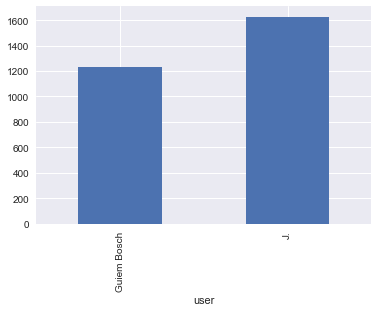

In [87]:
df_love.groupby("user")["user"].count().plot(kind='bar')

What about other ways to say it?

__Te quiero__

In [88]:
df[df['text'].str.contains(r"te quie+ro+\b.*", case=False) == True].groupby("user")["user"].count()

user
Guiem Bosch    62
J.             30
Name: user, dtype: int64

__Te amo__

In [89]:
df[df['text'].str.contains(r"te amo+\b.*", case=False) == True].groupby("user")["user"].count()

user
Guiem Bosch    25
J.             14
Name: user, dtype: int64

### LOVE distribution per weeks <a class="anchor" id="love_weeks"></a>

In [10]:
loves_week = df_love.groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

In [11]:
messages_week = df.groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

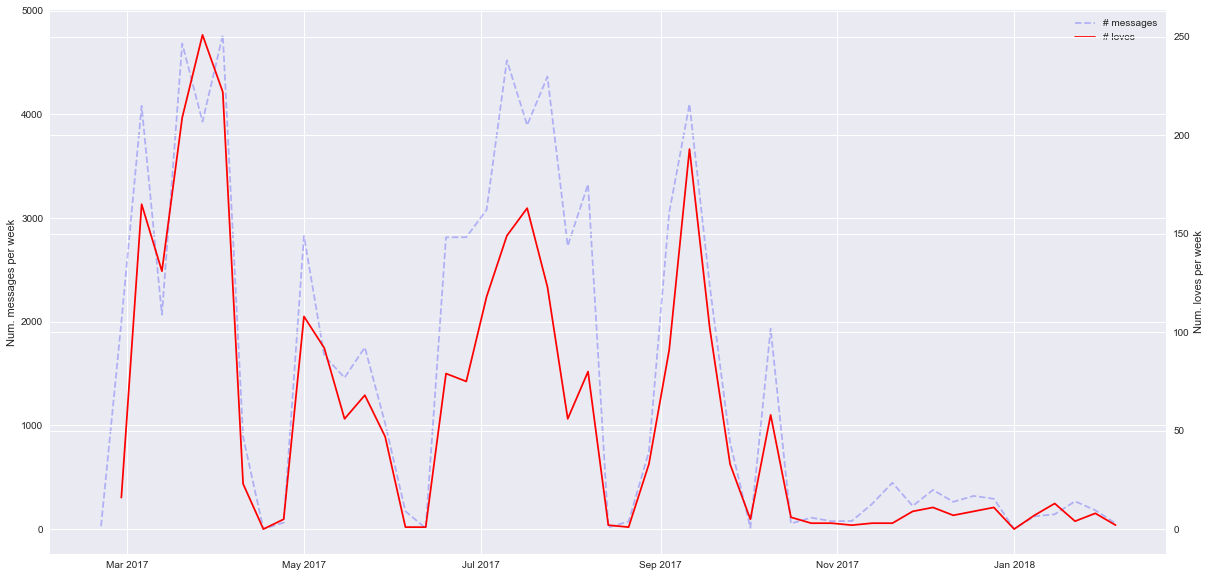

In [54]:
fig, ax = plt.subplots()
ax.plot(messages_week.text,'--',color='b',alpha=0.25,label='# messages')
ax.set_ylabel('Num. messages per week')
fig.set_size_inches(20,10)
ax2 = ax.twinx()
ax2.plot(loves_week.text,color='r',label='# loves')
ax2.set_ylabel('Num. loves per week')
lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='best')

It looks like there is a correlation between the number of messages exchanged and the number of times __love__ was  mentioned. Even though we are talking about different scales, the shape of the graphs is very similar!

Phew! If lots of messages were exchanged but no love talk involved we could probably be facing arguments. Awww, infatuation stage! 🗣️❤️

In [59]:
loves_week.text.corr(messages_week.text)

0.9283123266555763

Wow, Pearson's correlation is __Too Damn High__!

Btw, beware that we are combining two scales! Real proportion:

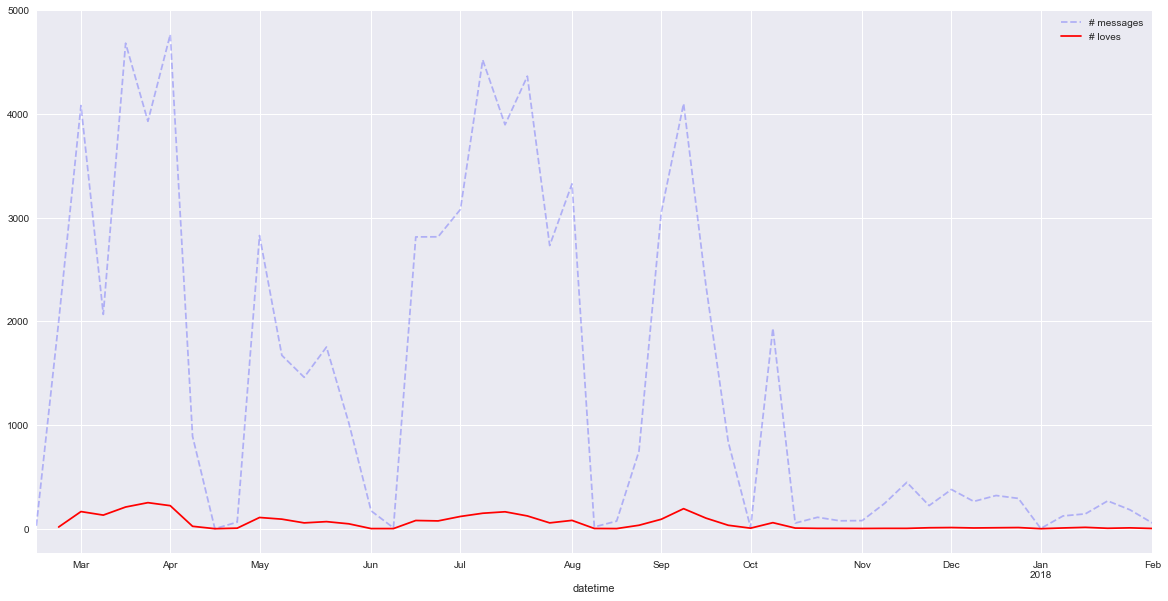

In [147]:
messages_week.text.plot(figsize=(20,10),style='--',color='b',alpha=0.25,label='# messages')
loves_week.text.plot(figsize=(20,10),color='r',label='# loves')
plt.legend(loc='best')

Wait! ~250 messages containing "I love you" __in a week__? Is that even possible?

In [78]:
loves_week.text.max()

251

In [85]:
loves_week.text.idxmax()

Timestamp('2017-03-27 00:00:00', offset='W-MON')

In [89]:
df_love_top_week = df_love[(df_love.datetime >= pd.datetime(2017,3,27)) & (df_love.datetime <= pd.datetime(2017,4,4))]

In [90]:
df_love_top_week.head()

,user,date,text,source,datetime
10918,J.,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you!!!!!!,facebook,2017-04-03 23:58:00
10921,Guiem Bosch,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you sooo much,facebook,2017-04-03 23:58:00
10922,J.,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you!!!!!!!💕❤️😘,facebook,2017-04-03 23:58:00
10925,Guiem Bosch,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you!,facebook,2017-04-03 23:58:00
10932,J.,"Monday, April 3, 2017 at 10:56pm UTC+01",Baby I love you!!!!!,facebook,2017-04-03 23:56:00


In [92]:
df_love_top_week.tail()

,user,date,text,source,datetime
16052,Guiem Bosch,"Monday, March 27, 2017 at 9:28am UTC+01","hahaha, I love you!!!",facebook,2017-03-27 10:28:00
16077,J.,"Monday, March 27, 2017 at 7:07am UTC+01",I love you SO SO SO,facebook,2017-03-27 08:07:00
16086,Guiem Bosch,"Monday, March 27, 2017 at 7:05am UTC+01",I love you!!!,facebook,2017-03-27 08:05:00
16315,J.,"Monday, March 27, 2017 at 5:18am UTC+01",i love you so much. i wish i could see you rig...,facebook,2017-03-27 06:18:00
16332,Guiem Bosch,"Monday, March 27, 2017 at 12:05am UTC+01",I love you.,facebook,2017-03-27 01:05:00


Yeah... it looks like it's possible 😅

### Any preferred days to communicate? <a class="anchor" id="preferred_days"></a>

In [93]:
week_days = {0:'0 - Monday',1:'1 - Tuesday',2:'2 - Wednesday',3:'3 - Thursday',4:'4 - Friday',5:'5 - Saturday',6:'6 - Sunday'}
df['weekday'] = df['datetime'].apply(lambda x: week_days[x.weekday()])

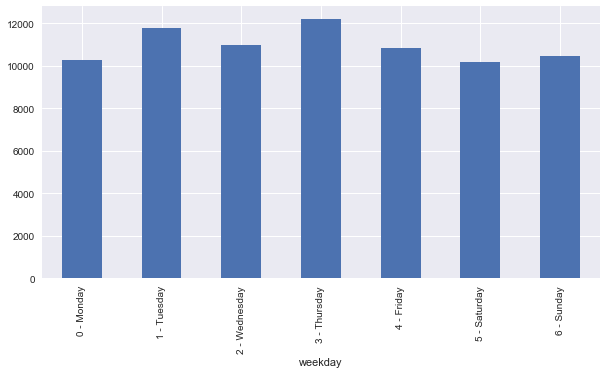

In [94]:
df.groupby('weekday')['datetime'].count().plot(kind='bar',figsize=(10,5))

Well, it doesn't look much significative (btw, what was happening on Tuesdays?)

### What about the hours? <a class="anchor" id="preferred_hours"></a>

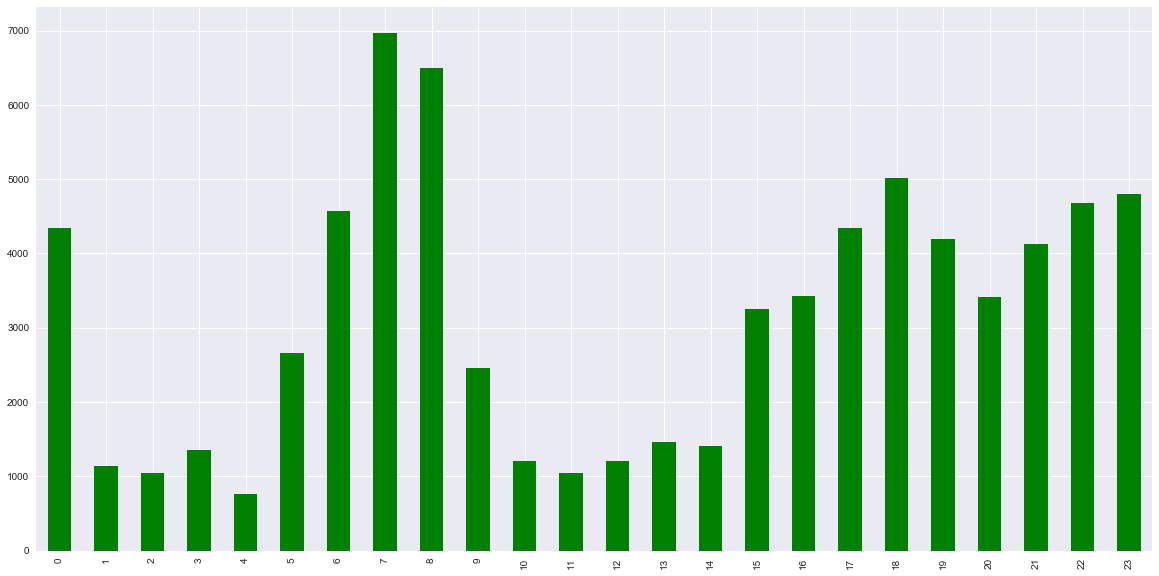

In [97]:
times = pd.DatetimeIndex(df.datetime)
df.groupby([times.hour]).text.count().plot(kind='bar',figsize=(20,10),color='g')

Timezones! ⏰   Ah, I would be usually 9hrs ahead of her time. We observe one peak at 7 a.m. (when I would wake up, her 10 p.m. of the previous day) and another peak around my 6 p.m. (her 9 a.m.). Basically we would communicate whenever one of us was waking up and the other was about to go to sleep and viceversa. Distance is tough when one's energy is 🌜 and the other's is ☀️   

## Playing with words (NLP) <a class="anchor" id="nlp"></a>

### Word frequency <a class="anchor" id="frequency"></a>

[will include word cloud]

#### Bigrams <a class="anchor" id="bigrams"></a>

#### Trigrams <a class="anchor" id="trigrams"></a>

### Topic detection <a class="anchor" id="topic"></a>

[global & weeks?]

### Sentiment analysis <a class="anchor" id="sentiment"></a>

## Annex <a class="anchor" id="annex"></a>

Of course we could remove punctuation or numbers, but let's consider this a quick approach were words are counted by whitespaces.

In [97]:
df['words_in_text'] = df.text.apply(lambda x: len(str(x).split(' ')))

In [98]:
words_day = df.reset_index().set_index("datetime").groupby([pd.TimeGrouper('d')])["words_in_text"].sum()

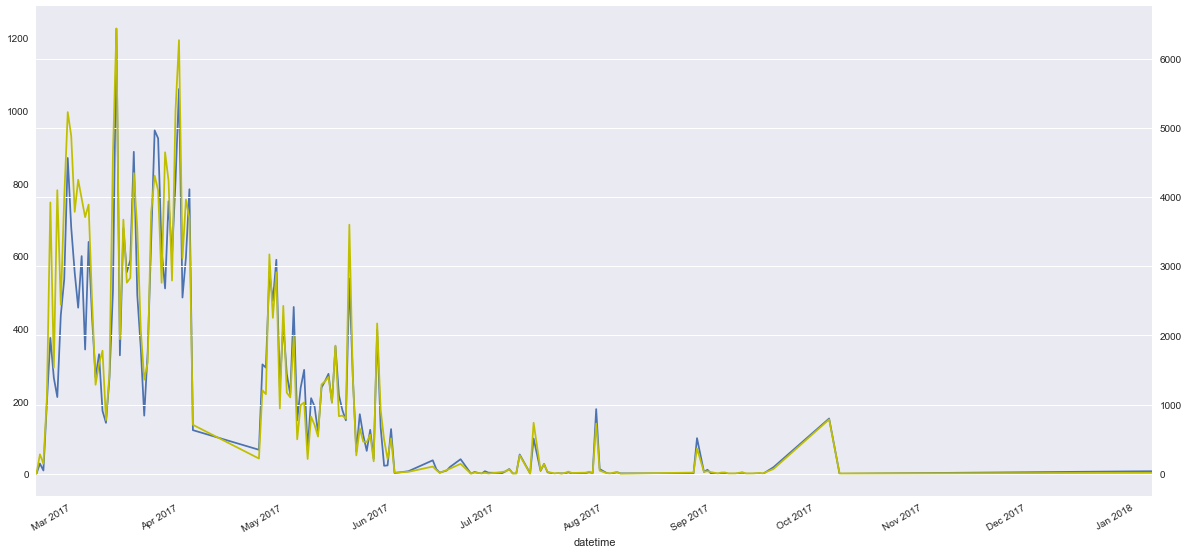

In [101]:
ax = messages_day.plot(figsize=(20,10))
words_day.plot(ax = ax,secondary_y=True,figsize=(20,10),style='y')

Let's zoom in for the first 3 months.

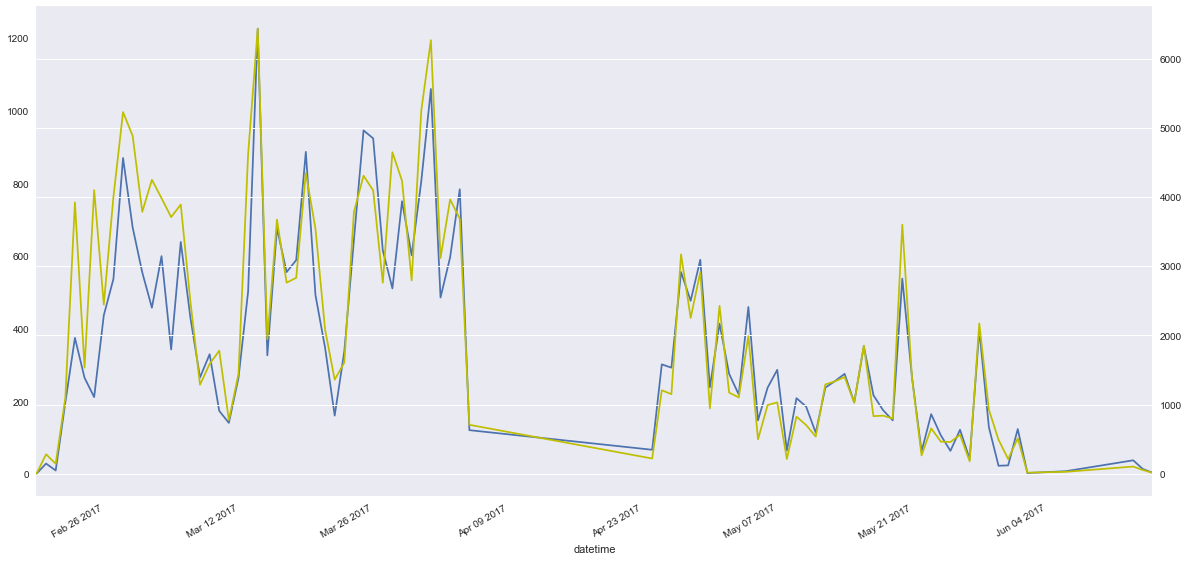

In [31]:
ax = messages_day[:90].plot(figsize=(20,10))
words_day[:90].plot(ax = ax,secondary_y=True,figsize=(20,10),style='y')

[draw number of words per day instead of messages - hypothesis, it could be the case that we exchanged piles of words in one single message]

[looks like hypothesis is not valid, I could zoom to appreciate some details and verify]